# Advanced Microeconometrics 
# Exam Task

In [1]:
# automatically reload external modules
%load_ext autoreload
%autoreload 2

import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

import tobit as tobit
import estimation
import LinearModels as lm

# automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading in the data

In [2]:
df = pd.read_csv('adv micro data.csv')
print(df.head())

y = df['y'].values
X = df['x'].values.reshape(-1,1)

print(f'Data has {y.shape[0]} observations and {X.shape[1]} features')

          y         x
0 -2.949143 -0.617175
1  0.000000  0.357731
2 -0.255997  0.600539
3  0.000000  0.123566
4  0.000000 -0.490995
Data has 1000 observations and 1 features


### Inspecting the data

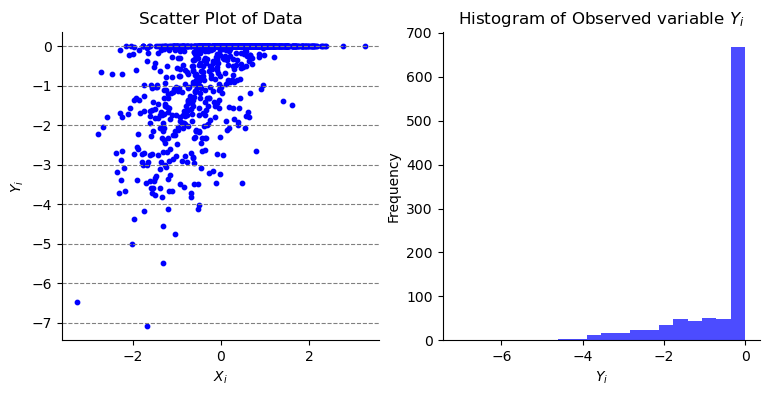

In [3]:
fig, ax = plt.subplots(1,2, figsize=(9,4))

ax[0].scatter(X, y, s=10, c='b', marker='o', label='Data')
ax[1].hist(y, bins=20, color='b', alpha=0.7, label='Data')

# remove spines 
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

# gridlines on the elft 
ax[0].yaxis.grid(color='gray', linestyle='dashed')

# add labels
ax[0].set_xlabel('$X_i$')
ax[0].set_ylabel('$Y_i$')
ax[1].set_xlabel('$Y_i$')
ax[1].set_ylabel('Frequency')

# title 
ax[0].set_title('Scatter Plot of Data')
ax[1].set_title('Histogram of Observed variable $Y_i$')

plt.show()

## Question 6: Estimate Tobit Model

$$ 
\ell_i(\theta) = \mathbf{1}\{y_i = 0\} \log\left[\Phi\left(\frac{\mathbf{x}_i \boldsymbol{\beta} + \mu}{\sigma}\right)\right] 
               + \mathbf{1}\{y_i < 0\} \log\left[\frac{1}{\sigma} \phi\left(\frac{y_i - \mathbf{x}_i \boldsymbol{\beta} - \mu}{\sigma}\right)\right] $$


* For the normal CDF and PDF: We use `norm.cdf` and `norm.cdf` from `scipy.stats`
* Since we are taking logs, it is good practice to ensure that we are not taking log of zero. Thus, we use `np.clip(vec, 1e-8, 1.0-1e-8)`, for example, to ensure that `vec` is within $[0.00000001; 0.99999999]$
* We force `sigma` to remain positive during estimation by taking `np.abs(sigma)` when unpacking parameters (in `loglikelihood`, e.g.)


In [4]:
# Calculate starting values using OLS
theta0 = tobit.starting_values(y, np.hstack((X,np.ones((X.shape[0],1)))))

# call the loglikelihood function 
ll0 = tobit.loglikelihood(theta0, y, X)
print(f'Log-likelihood of the starting values: {ll0}')

# Estimate the model using the Nelder-Mead method
res = estimation.estimate(tobit.q, theta0, y, X, cov_type='Outer Product', method='Nelder-Mead')

# Unfold the results
theta = res['theta'][0], res['theta'][1], res['theta'][2]
theta_se = res['se']
theta_t = res['t']

# Calculate the log-likelihood of the estimated model
print(f"Log-likelihood of procedure 1: {np.sum(tobit.loglikelihood(res['theta'], y, X))}")

Log-likelihood of the starting values: [ -3.362831    -1.11981144  -0.79069703  -1.29668105  -1.84475259
  -2.73324641  -2.71012575  -1.33960446  -1.74919577  -0.83511847
  -0.39228096  -0.99240188  -2.02120733  -0.78768021  -1.17390499
  -0.89371429  -1.61338979  -1.94060818  -1.36109778  -1.63763928
  -0.68563814  -1.60250497  -0.79208774  -1.46788369  -0.94689798
  -0.85177682  -0.93717796  -1.43689072  -1.36353048  -0.88331839
  -0.56950607  -0.90378256  -1.3769576   -0.98190463  -2.48505108
  -0.79409075  -1.22598768  -0.80025396  -0.93723638  -0.84702368
  -0.9056857   -0.85956907  -1.74605069  -0.92187259  -1.55828553
  -0.61095568  -2.30920461  -0.74167339  -0.83035269  -0.83711714
  -0.23480077  -0.8562134   -0.86102101  -1.0903397   -0.28702374
  -0.99422452  -0.48752945  -0.83785169  -0.74307114  -1.25697764
  -1.48675858  -0.62139139  -0.88544484  -0.87829556  -1.05075647
  -0.8890062   -0.93339994  -0.91764654 -20.50923783  -1.74681416
  -0.43534612  -0.74707261  -0.881080

Print results out in a neat table 

In [5]:
result_dict = {'thetahat': theta,
               'sd': theta_se, 
              't': theta_t}
lab_theta = ['x1', 'mu', 'sigma']

pd.DataFrame(result_dict, index=lab_theta).round(3)

,thetahat,sd,t
x1,1.437,0.074,19.430
mu,0.543,0.081,6.672
sigma,1.536,0.056,27.345


#### Calculate the predicted values of y and the residuals
Conditional mean of $Y_i$ given $X_i$ is given by (see Question 9):
$$
E(Y_i|X_i=x) = \left[1-\Phi\left(\frac{\beta_0x+\mu_0}{\sigma_0}\right)\right] \left[ \beta_0 x + \mu_0 \right] -
    \sigma_0 \phi\left(\frac{(\beta_0x+\mu_0)}{\sigma_0}\right)
$$

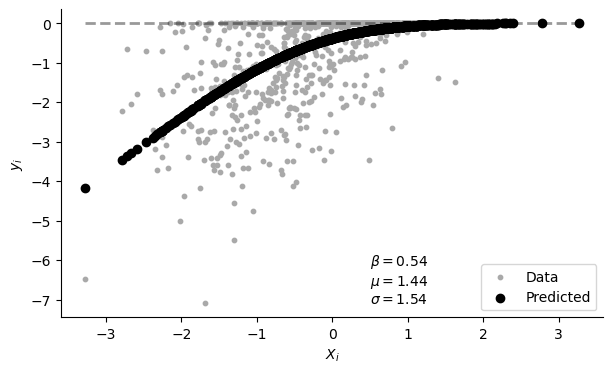

In [6]:
# Use the predict function to calculate the predicted values
yPred = tobit.predict(theta, X)

fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.hlines(y=0, xmin=X.min(), xmax=X.max(), color='black', linewidth=2, linestyle='--',alpha=0.4)

ax.scatter(X, y, s=10,  marker='o', label='Data', color='darkgrey')
ax.scatter(X, yPred,  label='Predicted', color='black', marker=None, linestyle='-', linewidth=1)
ax.set_xlabel('$X_i$')
ax.set_ylabel('$y_i$')
ax.legend(loc='lower right')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(0.5, y.min(), s=f'$\\beta = {theta[1]:.2f}$\n$\\mu = {theta[0]:.2f}$\n$\\sigma = {theta[2]:.2f}$',)

plt.show()

#### Marginal effects
We derived the conditional mean of the observable $Y_i$ on $X_i=x$ for the Tobit model in the previous question.

$$
\begin{align*}
E(Y_i|X_i=x)= \left[1-\Phi\left(\frac{\beta_0x+\mu_0}{\sigma_0}\right)\right] \left[ \beta_0 X_i + \mu_0 \right] -
    \sigma_0 \phi\left(\frac{(\beta_0x+\mu_0)}{\sigma_0}\right)
\end{align*}
$$

In order to determine if the partial effect is constant across $X_i$, we derive the partial effect on the conditional mean as: 
$$
\frac{\partial E(Y_i|X_i=x)}{\partial X_i} = \beta \left( 1-\Phi \left( \frac{\beta x + \mu}{\sigma}  \right) \right)
$$

We then conduct run OLS on the above equation to see whether there is a significant relationship between the partial effect and $X_i$. Thus if  has constant partial eﬀect on the conditional mean that must mean that $\beta>0$.

The null-hypothesis is that $\beta=0$ and the alternative hypothesis is that $\beta\ne0$.

 


In [7]:
#----- CALCULATE NUMERICAL GRADIENT -----
def conditional_mean_effect(x, b, mu, sigma):
    """ 
    Calculate the marginal effect of the tobit model
    """
    b = b.reshape(-1,1)
    inner = (x@b + mu )/ sigma 
    return (1-norm.cdf(inner))*(x@b+mu) - sigma*norm.pdf(inner)

# Unfuld the results
beta, mu, sigma = theta

# Calculate 
step = 1.49e-08

# Avoid changing the original data
x1 = np.copy(X) 
x_1 = np.copy(X)

# Change the x values by a small step
x1[:,0] = x1[:,0] + step
x_1[:,0] = x_1[:,0] - step

# Calculate the change in the conditional mean
grad = conditional_mean_effect(x1, np.array((beta)), mu, sigma) - conditional_mean_effect(x_1, np.array((beta)), mu, sigma)
# Divide by the step size in either direction
grad *= 1/(step*2)

In [8]:
#----- CALCULATE ANALYTICAL GRADIENT -----
analytical_grad = beta * (1-norm.cdf((X@beta.reshape(-1,1) + mu)/sigma) )

In [9]:
# OLS estimation of analytical_grad on X
ols_est = lm.estimate(analytical_grad, np.hstack((np.ones((X.shape[0],1)), X )), transform='',t=None, robust_se=True)

ols_X = np.linspace(X.min(), X.max(), 1000).reshape(-1,1)

ols_line = np.hstack((np.ones((ols_X.shape[0],1)), ols_X))@ols_est['b_hat']

ols_est

{'b_hat': array([[ 0.57071984],
        [-0.38646956]]),
 'se': array([0.00258593, 0.00467325]),
 'sigma2': array([[0.00643986]]),
 't_values': array([[ 220.70154154,  122.12470321],
        [-149.45060871,  -82.69815927]]),
 'R2': array([[0.95908172]]),
 'cov': array([[6.68705976e-06, 5.82103708e-06],
        [5.82103708e-06, 2.18393091e-05]])}

#### Plot the analytical gradients, numerical gradients and the OLS estimate

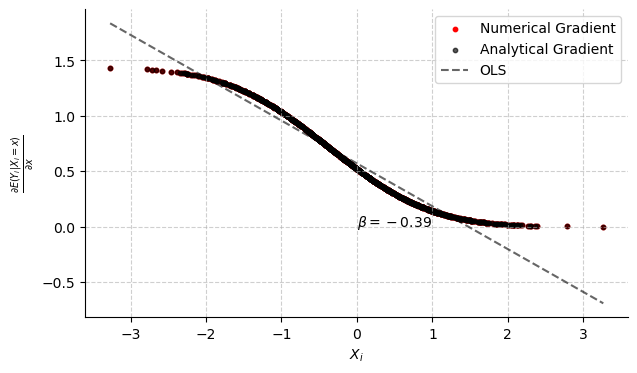

In [10]:
fig, ax = plt.subplots(1,1, figsize=(7,4))

ax.scatter(X, grad, s=10,  marker='o', label='Numerical Gradient', color='red')
ax.scatter(X, analytical_grad, s=10,  marker='o', label='Analytical Gradient', color='black',linestyle='-', linewidth=1, alpha=0.65)

# add ols line
ax.plot(np.linspace(X.min(), X.max(), 1000), ols_line, label='OLS', color='black', linestyle='--', alpha=0.6)

# add text showing the estimated coefficient
ax.text(0.0, grad.min(), s=f'$\\beta = {ols_est["b_hat"][1][0]:.2f}$',)
ax.legend(loc='upper right')


# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ylabel and xlabel
ax.set_ylabel('$\\frac{\partial E(Y_i|X_i=x)}{\partial x}$')
ax.set_xlabel('$X_i$')

# gridlines
ax.grid(True, linestyle='--', alpha=0.6)

plt.show()

# fig.savefig('marginal_effect.png', dpi=300)
